In [1]:
import os
import copy
# import warnings
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# warnings.filterwarnings('ignore')

In [2]:
def clear_file(file_path):
    with open(file_path, 'w') as _:
        pass

def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created successfully.")
    else:
        print(f"Folder '{folder_path}' already exists.")

create_folder('results')

Folder 'results' already exists.


In [3]:
output_file = 'results/output.txt'
clear_file(output_file)

def print_and_write(*args, **kwargs):
    with open(output_file, 'a') as append_to_file:
        __builtins__.print(*args, **kwargs, file=append_to_file)
        __builtins__.print(*args, **kwargs)

print = print_and_write

You are given a data-set with 400 data points in $\{0, 1\}^{50}$ generated from a mixture of some distribution in the file A2Q1.csv. Each datapoint is a flattened version of a $\{0, 1\}^{10×5}$ matrix.

In [4]:
data_file = 'A2Q1.csv'
data = np.genfromtxt('A2Q1.csv', delimiter=',')

print("Shape of the dataset:", data.shape)

Shape of the dataset: (400, 50)


In [5]:
epsilon = 1e-20

1. Determine which probabilisitic mixture could have generated this data (It is not a Gaussian mixture). Derive the EM algorithm for your choice of mixture and show your calculations. Write a piece of code to implement the algorithm you derived by setting the number of mixtures $K = 4$. Plot the log-likelihood (averaged over 100  random initializations) as a function of iterations.

In [6]:
class BernoulliMixtureEM:
    def __init__(self, num_components=4, max_iteration=50, tolerance=1e-10, num_random_inits=10):
        self.num_components = num_components
        self.max_iteration = max_iteration
        self.tolerance = tolerance
        self.num_random_inits = num_random_inits
        self.means = None
        self.weights = None
        self.log_likelihoods = None
        self.responsibilities = None

    def _e_step(self, data):
        num_points, num_features = data.shape
        self.responsibilities = np.zeros((num_points, self.num_components))
        for i in range(num_points):
            for k in range(self.num_components):
                self.responsibilities[i, k] = self.weights[k] * np.prod(self.means[:, k] ** data.T[:, i] * (1 - self.means[:, k]) ** (1 - data.T[:, i]))

        sum_responsibilities_k = np.sum(self.responsibilities, axis=1, keepdims=True)
        for i in range(num_points):
            for k in range(self.num_components):
                if sum_responsibilities_k[i, 0] !=0:
                    self.responsibilities[i, k] /= sum_responsibilities_k[i, 0]
                else:
                    self.responsibilities[i, k] = 0

        return self.responsibilities

    def _m_step(self, data):
        num_points, num_features = data.shape
        prev_means = copy.deepcopy(self.means)

        self.means = data.T @ self.responsibilities
        sum_responsibilities_N = np.sum(self.responsibilities, axis=0, keepdims=True)

        for i in range(num_features):
            for k in range(self.num_components):
                if sum_responsibilities_N[0, k] != 0:
                    self.means[i, k] /= sum_responsibilities_N[0, k]
                else:
                    self.means[i, k] = 0

        self.means = np.clip(self.means, 0, 1)
        self.weights = np.mean(self.responsibilities, axis=0)
        return prev_means

    def cluster_assignment(self, data):
        return self.responsibilities

    def _log_likelihood(self, data):
        num_points, num_features = data.shape
        log_probs = np.zeros((num_points, self.num_components))
        for i in range(num_points):
            for k in range(self.num_components):
                log_probs[i, k] = self.weights[k] * np.prod(self.means[:, k] ** data.T[:, i] * (1 - self.means[:, k]) ** (1 - data.T[:, i]))

        log_probs = np.maximum(log_probs, epsilon)
        log_likelihood = np.sum(np.log(np.sum(log_probs, axis=1)))
        return log_likelihood

    def fit(self, data):
        num_points, num_features = data.shape

        log_likelihoods = np.zeros((self.num_random_inits, self.max_iteration))

        for random_initialization in tqdm(range(self.num_random_inits), desc="Random Initialization", leave=False):
            np.random.seed(random_initialization)
            self.means = np.random.rand(num_features, self.num_components)
            self.weights = np.ones(self.num_components)
            self.weights /= np.sum(self.weights)
            log_likelihoods_per_init = []

            for itr in range(self.max_iteration):
                # E-step
                self.responsibilities = self._e_step(data)

                # M-step
                prev_means = self._m_step(data)

                # Log-likelihood
                log_likelihood_val = self._log_likelihood(data)
                log_likelihoods_per_init.append(log_likelihood_val)

                # Check for convergence
                if itr > 0 and np.max(np.abs(self.means - prev_means)) < self.tolerance:
                    break

            log_likelihoods_per_init = np.array(log_likelihoods_per_init)  # Convert to numpy array

            # Fill the remaining entries with the last computed log-likelihood value
            if len(log_likelihoods_per_init) < self.max_iteration:
                last_log_likelihood = log_likelihoods_per_init[-1]
                log_likelihoods_per_init = np.pad(log_likelihoods_per_init, (0, self.max_iteration - len(log_likelihoods_per_init)), constant_values=last_log_likelihood)

            log_likelihoods[random_initialization] = log_likelihoods_per_init

        self.log_likelihoods = np.mean(log_likelihoods, axis=0)

    def plot_log_likelihood(self, filename=None):
        plt.plot(np.arange(1, len(self.log_likelihoods) + 1), self.log_likelihoods, color='red')
        plt.xlabel('Iterations')
        plt.ylabel('Log-Likelihood')
        if filename:
            plt.savefig(filename, format='pdf', bbox_inches='tight')
        else:
            plt.show()

Bernoulli Mixture Model  ####################
Estimated Log-Likelihood:  -6634.358121844662
Weights:  [0.0025     0.2510236  0.72882715 0.01764925]
Means:  [[0.00000000e+000 8.96328288e-002 8.91844443e-002 1.72487084e-089]
 [0.00000000e+000 5.97733303e-002 1.06329029e-001 1.16863902e-120]
 [0.00000000e+000 1.09551451e-001 1.09765395e-001 1.56480887e-078]
 [0.00000000e+000 4.97961930e-002 9.94748620e-002 6.78152265e-058]
 [0.00000000e+000 1.19511650e-001 8.58750741e-002 1.36644334e-001]
 [0.00000000e+000 9.95921875e-002 1.16855469e-001 2.73811782e-001]
 [1.00000000e+000 1.13756097e-001 1.08727989e-001 1.24686608e-001]
 [0.00000000e+000 1.19510801e-001 7.20334966e-002 0.00000000e+000]
 [0.00000000e+000 9.95497172e-002 8.91990252e-002 7.46276486e-087]
 [1.00000000e+000 7.96739572e-002 1.30004851e-001 2.97400276e-001]
 [0.00000000e+000 1.59176656e-001 9.24123581e-002 2.94078650e-001]
 [0.00000000e+000 1.29469869e-001 1.26784322e-001 2.88746074e-001]
 [1.00000000e+000 1.23633720e-001 9.0736

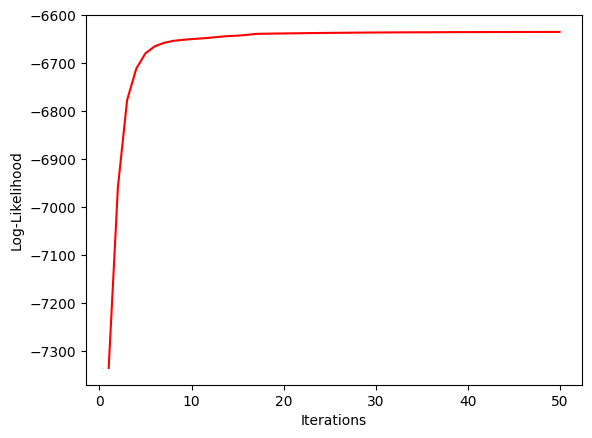

In [7]:
bmm = BernoulliMixtureEM(num_components=4, max_iteration=50, tolerance=1e-10, num_random_inits=100)
bmm.fit(data)
bmm.plot_log_likelihood(filename='results/bmm.pdf')

print('Bernoulli Mixture Model  ####################')
print('Estimated Log-Likelihood: ', bmm.log_likelihoods[-1])
print('Weights: ', bmm.weights)
print('Means: ', bmm.means)
print('Cluster assignment Probability: ', bmm.cluster_assignment(data))

2. Assume that the same data was infact generated from a mixture of Gaussians with 4 mixtures. Implement the EM algorithm and plot the log-likelihood (averaged over 100 random initializations of the parameters) as a function of iterations. How does the plot compare with the plot from part 1? Provide insights that you draw from this experiment.

In [8]:
class GaussianMixtureEM:
    def __init__(self, num_components=4, max_iteration=50, tolerance=1e-10, num_random_inits=100):
        self.num_components = num_components
        self.max_iteration = max_iteration
        self.tolerance = tolerance
        self.num_random_inits = num_random_inits
        self.means = None
        self.covariances = None
        self.weights = None
        self.log_likelihoods = None
        self.responsibilities = None

    def _e_step(self, data):
        num_points, num_features = data.shape
        log_responsibilities = np.zeros((num_points, self.num_components))
        epsilon = np.finfo(float).eps

        for k in range(self.num_components):
            for i in range(num_points):
                diff = data[i] - self.means[:, k]
                exponent = np.dot(diff.T, np.dot(np.linalg.inv(self.covariances[k]), diff))
                log_responsibilities[i, k] = np.log(self.weights[k]) - 0.5 * exponent

        self.responsibilities = np.maximum(np.exp(log_responsibilities), epsilon)

        sum_responsibilities_k = np.sum(self.responsibilities, axis=1, keepdims=True)
        for i in range(num_points):
            for k in range(self.num_components):
                self.responsibilities[i, k] /= sum_responsibilities_k[i, 0]

        return self.responsibilities

    def _m_step(self, data):
        num_points, num_features = data.shape
        prev_means = copy.deepcopy(self.means)

        self.means = data.T @ self.responsibilities
        sum_responsibilities_N = np.maximum(np.sum(self.responsibilities, axis=0, keepdims=True), epsilon)

        for k in range(self.num_components):
            self.covariances[k] *=0
            for i in range(num_points):
                diff = data[i] - self.means[:, k]
                self.covariances[k] += self.responsibilities[i, k]* np.outer(diff, diff.T)

        for k in range(self.num_components):
            if sum_responsibilities_N[0, k] != 0:
                self.covariances[k] /= sum_responsibilities_N[0, k]
            for i in range(num_features):
                if sum_responsibilities_N[0, k] != 0:
                    self.means[i, k] /= sum_responsibilities_N[0, k]
                    self.covariances[k] /= sum_responsibilities_N[0, k]

        self.means = np.clip(self.means, 0, 1)

        self.weights = np.mean(self.responsibilities, axis=0)
        return prev_means

    def cluster_assignment(self):
        return self.responsibilities

    def _log_likelihood(self, data):
        log_likelihood = 0
        num_points, num_features = data.shape
        log_probs = np.zeros((num_points, self.num_components))

        for k in range(self.num_components):
            for i in range(num_points):
                diff = data[i] - self.means[:, k]
                exponent = np.dot(diff, np.dot(np.linalg.inv(self.covariances[k]), diff.T))
                log_probs[i, k] = np.log(self.weights[k]) - 0.5 * exponent

        log_probs = np.clip(np.exp(log_probs), epsilon, 1)
        log_likelihood = np.sum(np.log(np.sum(log_probs, axis=1)))

        return log_likelihood

    def fit(self, data):
        num_points, num_features = data.shape
        log_likelihoods = np.zeros((self.num_random_inits, self.max_iteration))

        for random_initialization in tqdm(range(self.num_random_inits), desc="Random Initialization", leave=False):
            np.random.seed(random_initialization)
            self.means = np.random.rand(num_features, self.num_components)
            self.covariances = [np.eye(num_features) for _ in range(self.num_components)]

            self.weights = np.ones(self.num_components)
            self.weights /= np.sum(self.weights)
            log_likelihoods_per_init = []

            for itr in range(self.max_iteration):
                # E-step
                self.responsibilities = self._e_step(data)

                # M-step
                prev_means = self._m_step(data)

                # Log-likelihood
                log_likelihood_val = self._log_likelihood(data)
                log_likelihoods_per_init.append(log_likelihood_val)

                # Check for convergence
                if itr > 0 and np.max(np.abs(self.means - prev_means)) < self.tolerance:
                    break

            log_likelihoods_per_init = np.array(log_likelihoods_per_init)

            if len(log_likelihoods_per_init) < self.max_iteration:
                last_log_likelihood = log_likelihoods_per_init[-1]
                log_likelihoods_per_init = np.pad(log_likelihoods_per_init, (0, self.max_iteration - len(log_likelihoods_per_init)), constant_values=last_log_likelihood)

            log_likelihoods[random_initialization] = log_likelihoods_per_init

        self.log_likelihoods = np.mean(log_likelihoods, axis=0)

    def plot_log_likelihood(self, filename=None):
        plt.plot(np.arange(1, len(self.log_likelihoods) + 1), self.log_likelihoods, color='blue')
        plt.xlabel('Iterations')
        plt.ylabel('Log-Likelihood')
        if filename:
            plt.savefig(filename, format='pdf', bbox_inches='tight')
        else:
            plt.show()

In [9]:
data_mean = np.mean(data, axis=0)
data_covariance = np.cov(data, rowvar=False)

print('Mean vector shape: ', data_mean.shape)
print('Covariance matrix shape: ', data_covariance.shape)
print('Covariance matrix determinant: ', np.linalg.det(data_covariance))

Mean vector shape:  (50,)
Covariance matrix shape:  (50, 50)
Covariance matrix determinant:  2.7543550134960894e-53


Estimated Log-Likelihood:  -17866.162999504428
Weights:  [0.25 0.25 0.25 0.25]
Means:  [[0.0875 0.0875 0.0875 0.0875]
 [0.0925 0.0925 0.0925 0.0925]
 [0.1075 0.1075 0.1075 0.1075]
 [0.085  0.085  0.085  0.085 ]
 [0.095  0.095  0.095  0.095 ]
 [0.115  0.115  0.115  0.115 ]
 [0.1125 0.1125 0.1125 0.1125]
 [0.0825 0.0825 0.0825 0.0825]
 [0.09   0.09   0.09   0.09  ]
 [0.1225 0.1225 0.1225 0.1225]
 [0.1125 0.1125 0.1125 0.1125]
 [0.13   0.13   0.13   0.13  ]
 [0.7125 0.7125 0.7125 0.7125]
 [0.8725 0.8725 0.8725 0.8725]
 [0.9    0.9    0.9    0.9   ]
 [0.9175 0.9175 0.9175 0.9175]
 [0.885  0.885  0.885  0.885 ]
 [0.8875 0.8875 0.8875 0.8875]
 [0.915  0.915  0.915  0.915 ]
 [0.08   0.08   0.08   0.08  ]
 [0.0975 0.0975 0.0975 0.0975]
 [0.12   0.12   0.12   0.12  ]
 [0.685  0.685  0.685  0.685 ]
 [0.275  0.275  0.275  0.275 ]
 [0.86   0.86   0.86   0.86  ]
 [0.2975 0.2975 0.2975 0.2975]
 [0.7    0.7    0.7    0.7   ]
 [0.0775 0.0775 0.0775 0.0775]
 [0.1025 0.1025 0.1025 0.1025]
 [0.105  0.105

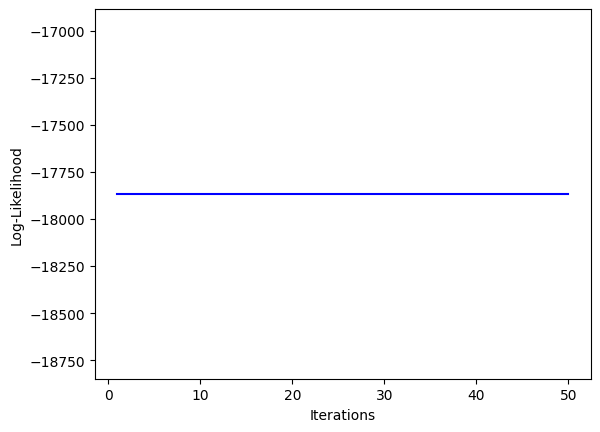

In [10]:
gmm = GaussianMixtureEM(num_components=4, max_iteration=50, tolerance=1e-10, num_random_inits=100)
gmm.fit(data)
gmm.plot_log_likelihood(filename='results/gmm.pdf')

print('Estimated Log-Likelihood: ', gmm.log_likelihoods[-1])
print('Weights: ', gmm.weights)
print('Means: ', gmm.means)
print('Covariance: ', gmm.covariances)
print('Cluster assignment Probability: ', gmm.cluster_assignment())

3. Run the $K$-means algorithm with $K = 4$ on the same data. Plot the objective of $K$ means as a function of iterations.

In [11]:
class KMeans:
    def __init__(self, k=4, max_iteration=50, tolerance=1e-10, k_means_plusplus=False):
        self.k = k
        self.max_iteration = max_iteration
        self.tolerance = tolerance
        self.k_means_plusplus = k_means_plusplus
        self.centroids = None
        self.labels = None
        self.n_samples = None
        self.n_features = None
        self.objective_value = []

    def fit(self, X):
        self.n_samples, self.n_features = X.shape

        if self.k_means_plusplus:
            self.centroids = self.k_means_plusplus_init(X)
        else:
            self.centroids = X[np.random.choice(self.n_samples, self.k, replace=False)]

        for iteration in tqdm(range(self.max_iteration), desc='Iteration', leave=False):
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            self.labels = np.argmin(distances, axis=1)

            new_centroids = np.array([X[self.labels == j].mean(axis=0) for j in range(self.k)])

            if np.linalg.norm(new_centroids - self.centroids) < self.tolerance:
                break

            self.centroids = new_centroids

            # Calculate objective value and record
            objective_value = self.calculate_objective_value(X)
            self.objective_value.append(objective_value)

        self.labels = np.argmin(distances, axis=1)
        return self.labels, self.centroids

    def plot_objective(self, filename=None):
        plt.plot(np.arange(1, len(self.objective_value) + 1), self.objective_value, color='blue')
        plt.xlabel('Iterations')
        plt.ylabel('Objective Value')
        if filename:
            plt.savefig(filename, format='pdf', bbox_inches='tight')
        else:
            plt.show()

    def k_means_plusplus_init(self, X):
        self.centroids = np.zeros((self.k, self.n_features), dtype=X.dtype)

        self.centroids[0] = X[np.random.choice(self.n_samples)]

        for i in range(1, self.k):
            min_distances = np.full((self.n_samples,), np.inf)

            for j in range(i):
                distances = np.linalg.norm(X - self.centroids[j], axis=1)
                min_distances = np.minimum(min_distances, distances)

            if np.all(min_distances == 0):
                self.centroids[i] = X[np.random.choice(self.n_samples)]
            else:
                min_distances[np.isnan(min_distances)] = 0

                if np.any(np.isnan(min_distances)) or np.any(min_distances == 0):
                    self.centroids[i] = X[np.random.choice(self.n_samples)]
                else:
                    probabilities = min_distances**2 / np.sum(min_distances**2)
                    probabilities[np.isnan(probabilities)] = 0
                    self.centroids[i] = X[np.random.choice(self.n_samples, p=probabilities)]

        return self.centroids

    def calculate_objective_value(self, X):
        distances = np.linalg.norm(X - self.centroids[self.labels], axis=1)
        return np.sum(distances**2)

    def log_likelihoods(self, X):
        n_samples = X.shape[0]
        distances = np.linalg.norm(X - self.centroids[self.labels], axis=1)
        log_likelihood = -np.sum(distances**2)
        return log_likelihood

    def cluster_assignment(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        min_distances = np.min(distances, axis=1, keepdims=True)
        responsibilities = np.exp(-distances**2 / min_distances**2)
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
        return responsibilities

Estimated Log-Likelihood:  -1746.187816915332
Cluster assignment Probability:  [[9.99999694e-01 1.01457675e-07 1.61481932e-07 4.29464466e-08]
 [9.95854032e-01 1.49641652e-03 1.60702613e-03 1.04252572e-03]
 [6.04713868e-01 1.32324296e-01 1.35159110e-01 1.27802726e-01]
 ...
 [7.42844395e-02 3.39356410e-01 2.87171138e-01 2.99188012e-01]
 [3.42465302e-02 3.56643191e-01 3.06767681e-01 3.02342598e-01]
 [7.04500617e-02 3.27607970e-01 2.78898165e-01 3.23043803e-01]]


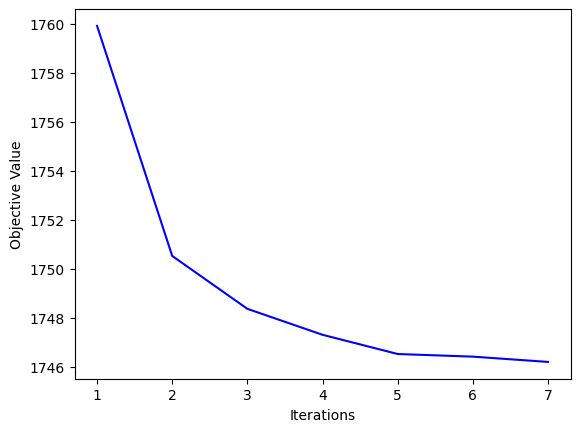

In [12]:
kmc = KMeans(k=4, max_iteration=50, tolerance=1e-10, k_means_plusplus=True)
kmc.fit(data)
kmc.plot_objective(filename='results/kmc.pdf')

print('Estimated Log-Likelihood: ', kmc.log_likelihoods(data))
print('Cluster assignment Probability: ', kmc.cluster_assignment(data))